### Speech Commands audio classification

In [1]:
import torch
import torchaudio
import IPython
import librosa
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from torch import nn
from torchsummary import summary
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from torch.utils.data import DataLoader, random_split

from model import *
from functions import *


print(torch.__version__)
print(torchaudio.__version__)

2.1.0
2.1.0


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
# download datasets from torchaudio

train_dataset = torchaudio.datasets.SPEECHCOMMANDS('.', 'speech_commands_v0.02', 'SpeechCommands', download=False, subset='training')
test_dataset = torchaudio.datasets.SPEECHCOMMANDS('.', 'speech_commands_v0.02', 'SpeechCommands', download=False, subset='testing')
val_dataset = torchaudio.datasets.SPEECHCOMMANDS('.', 'speech_commands_v0.02', 'SpeechCommands', download=False, subset='validation')


In [5]:
print( f'nr of observations in train set : {len(train_dataset)}')
print( f'nr of observations in test set : {len(test_dataset)}')
print( f'nr of observations in validation set : {len(val_dataset)}')
print(f'total length : {len(train_dataset)+len(test_dataset)+len(val_dataset)}')

nr of observations in train set : 84843
nr of observations in test set : 11005
nr of observations in validation set : 9981
total length : 105829


In [6]:
# to encode labels

labels = [sample[2] for sample in tqdm(val_dataset)]
labels = set(labels)
labels = list(labels)
print(f'{len(labels)} mots au total : {labels}')

100%|█████████████████████████████████████████████████████████████████████████████| 9981/9981 [00:53<00:00, 188.30it/s]

35 mots au total : ['left', 'bed', 'no', 'bird', 'off', 'four', 'five', 'dog', 'go', 'one', 'three', 'learn', 'yes', 'down', 'follow', 'forward', 'sheila', 'tree', 'six', 'backward', 'eight', 'zero', 'stop', 'nine', 'right', 'house', 'wow', 'visual', 'up', 'happy', 'on', 'cat', 'two', 'seven', 'marvin']


In [7]:
# Create a class for the Dataset (subclass of Dataset) and only keep the 3 valuable features
# Apply necessary transformations to the data

class ModifiedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, transformation, target_sample_rate, nr_samples, labels):
        self.original_dataset = original_dataset
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.nr_samples = nr_samples
        self.labels = labels
        self.encoder = LabelEncoder()

        self.encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):

        og_waveform, og_sample_rate, og_label, speaker_id, utterance = self.original_dataset[idx]

#         waveform = og_waveform.to(self.device)
        waveform = self._resample(og_waveform, og_sample_rate)
        waveform = self._mix_down(waveform)
        waveform = self._trim(waveform)
        waveform = self._zero_pad(waveform)
        spectrogram = self.transformation(waveform)

        encoded_label = self.encoder.transform([og_label])
        encoded_label = encoded_label.squeeze().astype(np.int64)

        return waveform, og_sample_rate, encoded_label, spectrogram, og_label

    def _resample(self, wvf, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sample_rate)
            wvf = resampler(wvf)
        return wvf

    def _mix_down(self, wvf):
        if wvf.shape[0] > 1:
            wvf = torch.mean(wvf, dim=0, keepdim=True)
        return wvf

    def _trim(self, wvf):
        if wvf.shape[1] > self.nr_samples :
            excess_samples = wvf.shape[1] - self.nr_samples
            left_trim = excess_samples // 2
            right_trim = excess_samples - left_trim
            wvf = wvf[:, left_trim:-right_trim]
        return wvf

    def _zero_pad(self, wvf):
        if wvf.shape[1] < self.nr_samples :
            nr_missing_samples = self.nr_samples - wvf.shape[1]
            wvf = torch.nn.functional.pad(wvf, (0, nr_missing_samples))
        return wvf

In [8]:
# create the updated datasets
fixed_sample_rate = 16000 #16000
num_samples = 16000 #16000
n_fft = 1024 #512 #1024
hop_length = 512
n_mels = 128 #64
n_mfcc = 40


transfo_mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=fixed_sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        mel_scale="htk")

transfo_mfcc = torchaudio.transforms.MFCC(
        sample_rate=fixed_sample_rate,
        n_mfcc=n_mfcc,
        dct_type=2,
        norm='ortho',
        log_mels=False)

transfo_spectro = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        hop_length = hop_length,
        power=2.0,
        normalized=False,
        center=True,
        pad_mode='reflect',
        onesided=True,
        return_complex=None)

C:\ProgramData\Anaconda3\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [9]:
# choose which transformation to apply to the waveforms + adjust necessary parameters/variables :

# transfo = 'mel_spectrogram'
transfo = 'mfcc'
# transfo = 'spectrogram'


if transfo == 'mel_spectrogram' :
    transformation = transfo_mel
    cnn = CNN_mel()
    best_model = CNN_mel()
    random_tensor = torch.rand([64,1,128,32]).to(device)

elif transfo == 'mfcc':
    transformation = transfo_mfcc
    cnn = CNN_mfcc()
    best_model = CNN_mfcc()
    random_tensor = torch.rand([64,1,40,81]).to(device)

elif transfo == 'spectrogram':
    transformation = transfo_spectro
    cnn = CNN_spectro()
    best_model = CNN_spectro()
    random_tensor = torch.rand([64,1,513,32]).to(device)


In [10]:
# create new datasets

def modify_data(original_dataset):
    return ModifiedDataset(original_dataset, transformation, fixed_sample_rate, num_samples, labels)

modif_train = modify_data(train_dataset)
modif_test = modify_data(test_dataset)
modif_val = modify_data(val_dataset)

In [11]:
# unload original datasets to free up memory

del train_dataset, test_dataset, val_dataset

In [12]:
modif_train

11005it [00:53, 206.26it/s]


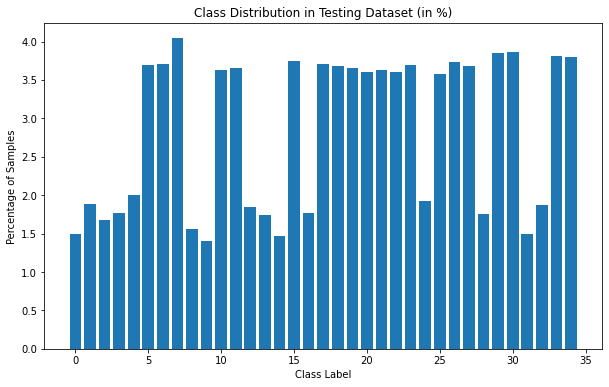

9981it [00:45, 217.23it/s]


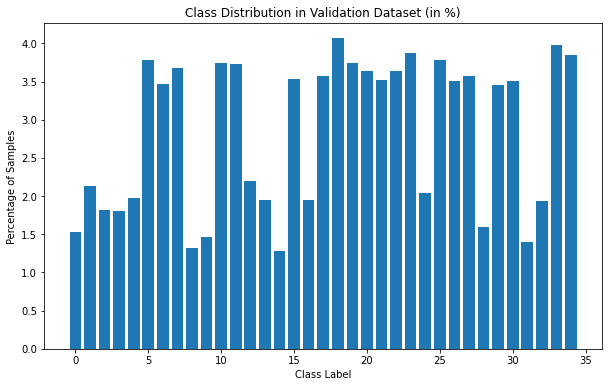

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [02:19<00:00, 179.25it/s]


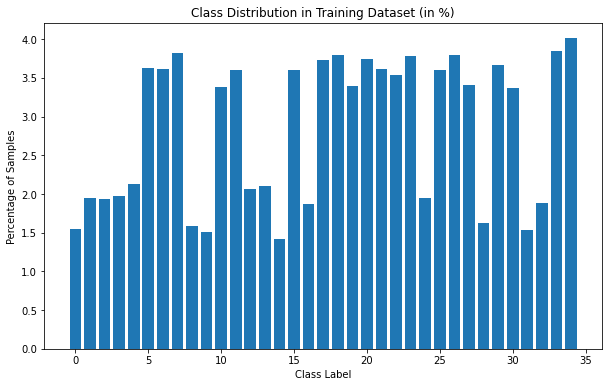

In [13]:
# Check if the dataset is balanced over all the classes

class_distribution_percent_test, class_weights_test = class_distrib(modif_test, 'Testing Dataset')
# class_distribution_percent_train, class_weights_train = class_distrib(modif_train, 'Training Dataset')
class_distribution_percent_val, class_weights_val = class_distrib(modif_val, 'Validation Dataset')

# for an approximation of num_samples size (less computations) :
num_samples = 25000
class_distribution_percent_train, class_weights_train = class_distrib_approx(modif_train, num_samples, 'Training Dataset')


In [14]:
# Convert the class_weights dictionary to a tensor (for the loss)

## TRANSFORMER EN FONCTION

weights_list_test = [class_weights_test[i] for i in range(len(class_weights_test))]
weights_list_train = [class_weights_train[i] for i in range(len(class_weights_train))]
weights_list_val = [class_weights_val[i] for i in range(len(class_weights_val))]

class_weights_test_tensor = torch.tensor(weights_list_test, dtype=torch.float).to(device)
class_weights_train_tensor = torch.tensor(weights_list_train, dtype=torch.float).to(device)
class_weights_val_tensor = torch.tensor(weights_list_val, dtype=torch.float).to(device)


Dataset modif_train - Number of Samples: 84843
Dataset modif_test - Number of Samples: 11005
Dataset modif_val - Number of Samples: 9981


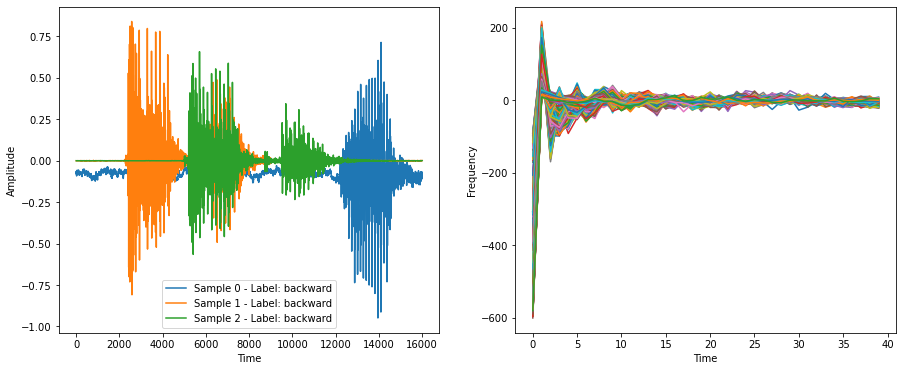

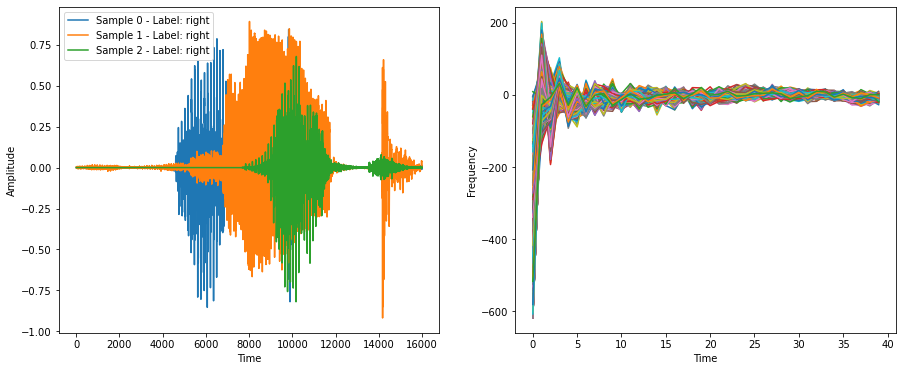

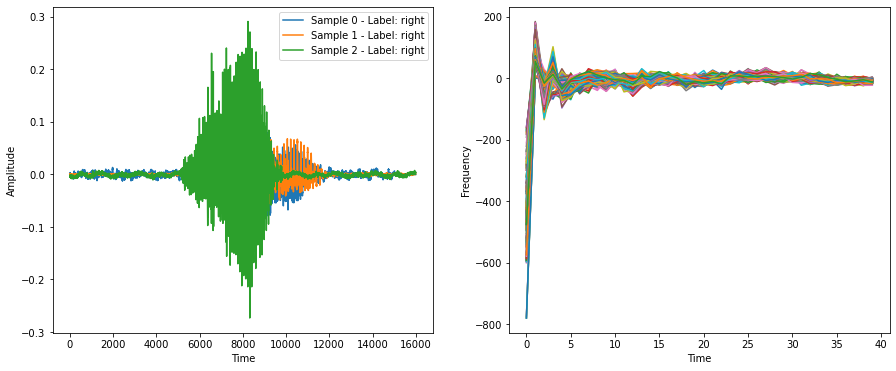

In [15]:
# see what's inside (plot waveforms and mel_spectrograms)
number_of_samples = 3
dataset_names = ["modif_train", "modif_test", "modif_val"]
datasets = [modif_train, modif_test, modif_val]


for dataset, dataset_name in zip(datasets, dataset_names):

    plt.figure(figsize=(15,6))
    print(f"Dataset {dataset_name} - Number of Samples: {len(dataset)}")
    plt.title(f"Dataset {dataset_name}")

    plt.clf()

    ax = plt.subplot(121)
    for i in range(number_of_samples):
        waveform, sample_rate, label, spectrogram, og_label = dataset[i]
        ax.plot(waveform.t(), label=f"Sample {i} - Label: {og_label}")
        ax.legend()

    plt.xlabel("Time")
    plt.ylabel("Amplitude")

    ax = plt.subplot(122)
    for i in range(number_of_samples):
        waveform, sample_rate, label, spectrogram, og_label = dataset[i]
        ax.plot(spectrogram.squeeze(), label=f"Sample {i} - Label: {og_label}")
#        ax.legend()

    plt.xlabel("Time")
    plt.ylabel("Frequency")

plt.show()

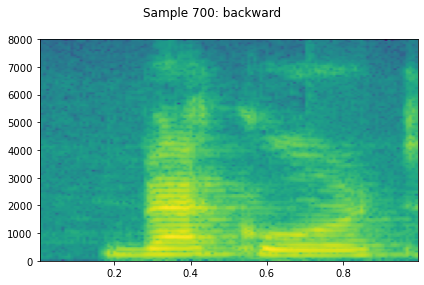

In [16]:
i = 700
waveform, sample_rate, label, _, og_label = modif_train[i]
plot_specgram(waveform, sample_rate, title=f"Sample {i}: {og_label}")
IPython.display.Audio(waveform, rate=sample_rate)

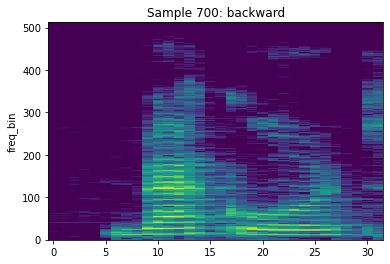

In [17]:
i = 700
waveform, sample_rate, label, _, og_label = modif_train[i]
plot_spectrogram(torchaudio.transforms.Spectrogram(n_fft=n_fft)(waveform).squeeze(), title=f"Sample {i}: {og_label}")
IPython.display.Audio(waveform, rate=sample_rate)


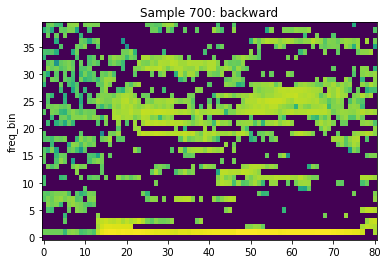

In [18]:
i = 700
waveform, sample_rate, label, spectrogram, og_label = modif_train[i]
plot_spectrogram(spectrogram[0], f"Sample {i}: {og_label}") #'MFCC'
IPython.display.Audio(waveform, rate=sample_rate)


In [19]:
# #check that they all have the same sample rate and number of samples (in validation subset)

# samplerate_val = []
# waveforms_val = []

# for i in tqdm(range(len(modif_val))):
#     waveform, sr , _ , _ = modif_val[i]
#     waveforms_val.append(waveform.shape[1])
#     samplerate_val.append(sr)


# print(f'Same number of samples : {all(wf == waveforms_val[0] for wf in waveforms_val)}')
# print(f'Same sample rate : {all(sr == samplerate_val[0] for sr in samplerate_val)}')


In [20]:
# load the data into DataLoaders
batch_size = 64
train_dataloader = DataLoader(modif_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(modif_test, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(modif_val, batch_size=batch_size, shuffle=False)

In [21]:
# Build the model


In [22]:
# if transfo == 'mel_spectrogram' :
#   cnn = CNN()
# elif transfo == 'mfcc':
#   cnn = CNN_mfcc()
# elif transfo == 'spectrogram':
#   cnn = CNN_spectro()

cnn.to(device)

train_criterion = nn.CrossEntropyLoss(weight=class_weights_train_tensor)
test_criterion = nn.CrossEntropyLoss(weight=class_weights_test_tensor)
val_criterion = nn.CrossEntropyLoss(weight=class_weights_val_tensor)

optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001)


In [23]:
# Model summary
input_size = modif_train[0][3].shape
summary(cnn, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 38, 79]              80
              ReLU-2            [-1, 8, 38, 79]               0
         MaxPool2d-3            [-1, 8, 19, 39]               0
            Conv2d-4           [-1, 16, 15, 35]           3,216
              ReLU-5           [-1, 16, 15, 35]               0
         MaxPool2d-6            [-1, 16, 7, 17]               0
            Conv2d-7            [-1, 32, 5, 15]           4,640
              ReLU-8            [-1, 32, 5, 15]               0
         MaxPool2d-9             [-1, 32, 2, 7]               0
          Flatten-10                  [-1, 448]               0
           Linear-11                  [-1, 128]          57,472
           Linear-12                   [-1, 64]           8,256
           Linear-13                   [-1, 35]           2,275
          Softmax-14                   

In [24]:
# try with a random tensor of the right dimensions

cnn(random_tensor)[0]

tensor([ 0.0233,  0.1190,  0.0298, -0.0596, -0.0082, -0.0204,  0.0910,  0.1051,
         0.0195,  0.0051,  0.0515,  0.0016, -0.0013,  0.0384, -0.0658, -0.0281,
         0.0557,  0.1018, -0.0046, -0.0693,  0.0191,  0.0911,  0.0655, -0.0208,
         0.0696,  0.1006, -0.0844, -0.0793, -0.0068,  0.1101, -0.0899, -0.0575,
         0.0225,  0.0034, -0.1181], grad_fn=<SelectBackward0>)

In [25]:
# train the network

n_epochs = 20
current_datetime = datetime.now()
date_string = current_datetime.strftime("%d.%m.%Y_%H-%M")
saving_path = f'outputs/{transfo}_{n_epochs}_eps_{date_string}.pth'

train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(cnn, train_dataloader, val_dataloader, optimizer, train_criterion, val_criterion, device, n_epochs, saving_path)

Train Epoch: 0 [0/84843 (0%)]	Loss: 3.681583
Train Epoch: 0 [6400/84843 (8%)]	Loss: 3.307681
Train Epoch: 0 [12800/84843 (15%)]	Loss: 2.606017
Train Epoch: 0 [19200/84843 (23%)]	Loss: 1.636042
Train Epoch: 0 [25600/84843 (30%)]	Loss: 1.991683
Train Epoch: 0 [32000/84843 (38%)]	Loss: 1.352585
Train Epoch: 0 [38400/84843 (45%)]	Loss: 1.664580
Train Epoch: 0 [44800/84843 (53%)]	Loss: 1.186553
Train Epoch: 0 [51200/84843 (60%)]	Loss: 1.142423
Train Epoch: 0 [57600/84843 (68%)]	Loss: 1.458255
Train Epoch: 0 [64000/84843 (75%)]	Loss: 0.974570
Train Epoch: 0 [70400/84843 (83%)]	Loss: 1.288857
Train Epoch: 0 [76800/84843 (90%)]	Loss: 0.799697
Train Epoch: 0 [83200/84843 (98%)]	Loss: 1.077165
epoch n.0 : Average Loss = 1.682351026015404, Accuracy = 50.84%
epoch n.0 : Val Average Loss = 0.9803243638613285, Val Accuracy = 70.22%
Train Epoch: 1 [0/84843 (0%)]	Loss: 1.204192
Train Epoch: 1 [6400/84843 (8%)]	Loss: 0.827726
Train Epoch: 1 [12800/84843 (15%)]	Loss: 0.983568
Train Epoch: 1 [19200/84843

epoch n.9 : Val Average Loss = 0.5575084589087428, Val Accuracy = 83.91%
Train Epoch: 10 [0/84843 (0%)]	Loss: 0.291422
Train Epoch: 10 [6400/84843 (8%)]	Loss: 0.407754
Train Epoch: 10 [12800/84843 (15%)]	Loss: 0.374890
Train Epoch: 10 [19200/84843 (23%)]	Loss: 0.568151
Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.256502
Train Epoch: 10 [32000/84843 (38%)]	Loss: 0.250804
Train Epoch: 10 [38400/84843 (45%)]	Loss: 0.495124
Train Epoch: 10 [44800/84843 (53%)]	Loss: 0.345880
Train Epoch: 10 [51200/84843 (60%)]	Loss: 0.192047
Train Epoch: 10 [57600/84843 (68%)]	Loss: 0.608935
Train Epoch: 10 [64000/84843 (75%)]	Loss: 0.313163
Train Epoch: 10 [70400/84843 (83%)]	Loss: 0.651525
Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.368964
Train Epoch: 10 [83200/84843 (98%)]	Loss: 0.463376
epoch n.10 : Average Loss = 0.4052082479089993, Accuracy = 87.03%
epoch n.10 : Val Average Loss = 0.5999905551509119, Val Accuracy = 82.77%
Train Epoch: 11 [0/84843 (0%)]	Loss: 0.397513
Train Epoch: 11 [6400/84843 (8%)]	

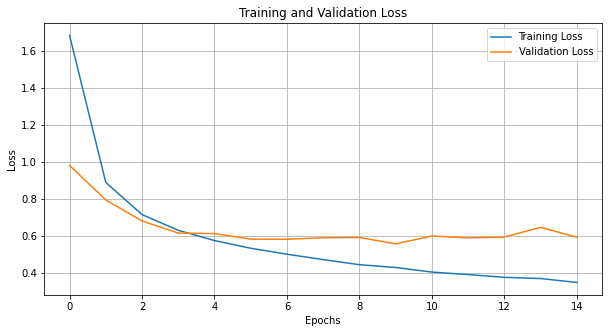

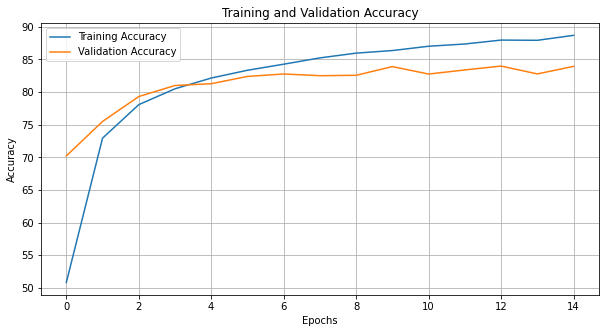

In [26]:
# plot learning curves

# Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()
plt.gca().set_facecolor('white')
file_name = f"outputs/losses_{transfo}_{date_string}.png"
plt.savefig(file_name, bbox_inches='tight', pad_inches=0.15,facecolor='white', transparent=False)
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid()
plt.gca().set_facecolor('white')
file_name = f"outputs/accuracies_{transfo}_{date_string}.png"
plt.savefig(file_name, facecolor='white', transparent=False, bbox_inches='tight', pad_inches=2)
plt.show()


In [27]:
# After training, to load the best model for inference or evaluation

# if transfo == 'mel_spectrogram' :
#   best_model = CNN_mel()
# elif transfo == 'mfcc':
#   best_model = CNN_mfcc()
# elif transfo == 'spectrogram':
#   best_model = CNN_spectro()


state_dict = torch.load(saving_path, map_location=device)
best_model.load_state_dict(state_dict)
best_model.to(device)

CNN_mfcc(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=448, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=35, bias=True)
  (softmax): Softmax

In [28]:
test_loss, test_accuracy = test_model(best_model, test_dataloader, test_criterion, device)


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [01:52<00:00,  1.53it/s]


Test set: Average loss: 0.0114, Accuracy: 8881/11005 (80.7%)



In [29]:
# Prediction/Inference on test data

i = random.randint(0,len(test_dataloader.dataset)-1)
input_data = test_dataloader.dataset[i][3].to(device)
target = test_dataloader.dataset[i][2] #.astype(np.int64)

predicted_label, expected_label = predict(best_model, input_data, target, labels)
print(f"Predicted label : {predicted_label}, Expected label : {expected_label}")

Predicted label : backward, Expected label : backward
